In [4]:
%matplotlib inline
from collections import defaultdict
import cPickle as pickle
import numpy as np
import argparse
import os
import matplotlib.pyplot as pyplot
import colorbrewer as cb
from scipy.stats.stats import pearsonr
import math
import fnmatch
from matplotlib import rcParams
rcParams.update({'font.size': 10})

In [5]:
def list_files_or_dir(file_or_dir_list, suffix='*', containing='*'):
    if type(file_or_dir_list) != list: return file_or_dir_list
    files = []
    for file_or_dir in file_or_dir_list:
        if os.path.isdir(file_or_dir):
            for root, dirnames, filenames in os.walk(file_or_dir):
                for filename in fnmatch.filter(filenames, '*%s*%s' % (containing, suffix)):
                    files.append(os.path.join(root, filename))
        else:
            files.append(file_or_dir)
    return files


def get_color(tissue):
    colors_dict = {'rest': '#%02x%02x%02x' % cb.Paired[10][-1],
               'stim': '#%02x%02x%02x' % cb.Paired[10][-2],
               'cer': '#%02x%02x%02x' % cb.Paired[10][-3],
               'liv': '#%02x%02x%02x' % cb.Paired[10][-4]
               }
    return colors_dict[tissue]


def scatterplot_rtpcr_majiq_miso(rt_pcr_majiq, rt_pcr_miso, majiq, miso, plotpath, 
                                 pcr_majiq_extra=None, pcr_miso_extra=None, 
                                 majiq_extra=None, miso_extra=None):
    #figure out how many groups of events exist
    nrows = 2
    ncols = 5
    fig, axx = pyplot.subplots(nrows, ncols, sharex=True, sharey=True, figsize=[15, 6], dpi=300)
    fig.suptitle("PSI comparison: RT-PCR Vs MAJIQ; RT-PCR Vs MISO")
    datasets = [
        [
            {'data': [majiq, rt_pcr_majiq, majiq_extra, pcr_majiq_extra], 'label': 'All'},
            {'data': [majiq[0], rt_pcr_majiq[0]], 'color': get_color('rest'), 'label': 'Resting', 'marker': '.'},
            {'data': [majiq[1], rt_pcr_majiq[1]], 'color': get_color('stim'), 'label': 'Stimulating', 'marker': '.'},
            {'data': [majiq_extra[0], pcr_majiq_extra[0]], 'color': get_color('cer'), 'label': 'Cerebellum', 'marker': 'd'},
            {'data': [majiq_extra[1], pcr_majiq_extra[1]], 'color': get_color('liv'), 'label': 'Liver', 'marker': 'd'}
        ],
        [
            {'data': [miso, rt_pcr_miso, miso_extra, pcr_miso_extra], 'label': 'All'},
            {'data': [miso[0], rt_pcr_miso[0]], 'color': get_color('rest'), 'label': 'Resting', 'marker': '.'},
            {'data': [miso[1], rt_pcr_miso[1]], 'color': get_color('stim'), 'label': 'Stimulating', 'marker': '.'},
            {'data': [miso_extra[0], pcr_miso_extra[0]], 'color': get_color('cer'), 'label': 'Cerebellum', 'marker': 'd'},
            {'data': [miso_extra[1], pcr_miso_extra[1]], 'color': get_color('liv'), 'label': 'Liver', 'marker': 'd'}    
        ]
    ]
    xlabels = ['MAJIQ', 'MISO']
    
    for nrow in xrange(nrows):
        for ncol in xrange(ncols):
            if ncol == 0:  # Special case, aggregated for all 
                
                met_all = [a for b in datasets[nrow][ncol]['data'][0] for a in b]
                pcr_all = [a for b in datasets[nrow][ncol]['data'][1] for a in b]              
                
                met_extra_all = [a for b in datasets[nrow][ncol]['data'][2] for a in b]
                pcr_extra_all = [a for b in datasets[nrow][ncol]['data'][3] for a in b]                
                
                met_comb = np.append(met_all, met_extra_all)
                pcr_comb = np.append(pcr_all, pcr_extra_all)
                
                diagonal = np.linspace(0, 1, num=10)
                fit = np.polyfit(met_comb, pcr_comb, 1)
                fit_fn = np.poly1d(fit) # fit_fn is now a function which takes in x and returns an estimate for y
                pearson_f = pearsonr(met_comb, pcr_comb)[0]

                axx[nrow][ncol].text(.1, .9, 'R=%.2f' % (math.ceil(pearson_f*100)/100), fontsize=14)
                axx[nrow][ncol].plot(met_comb, fit_fn(met_comb), '--k')
                axx[nrow][ncol].plot(diagonal, diagonal, '--', color="#cccccc")
                
                for ii in xrange(1,5):
                    axx[nrow][ncol].plot(datasets[nrow][ii]['data'][0], 
                                   datasets[nrow][ii]['data'][1], 
                                   datasets[nrow][ii]['marker'], 
                                   color=datasets[nrow][ii]['color'], 
                                   label=datasets[nrow][ii]['label'])
                nelems = sum([len(dd) for dd in datasets[nrow][ncol]['data'][0]]) + sum([len(dd) for dd in datasets[nrow][ncol]['data'][2]])
            else:
                diagonal = np.linspace(0, 1, num=10)
                fit = np.polyfit(datasets[nrow][ncol]['data'][0], datasets[nrow][ncol]['data'][1], 1)
                fit_fn = np.poly1d(fit) # fit_fn is now a function which takes in x and returns an estimate for y
                pearson_f = pearsonr(datasets[nrow][ncol]['data'][0], datasets[nrow][ncol]['data'][1])[0]
                axx[nrow][ncol].text(.1, .9, 'R=%.2f' % (math.ceil(pearson_f*100)/100), fontsize=14)
                axx[nrow][ncol].plot(datasets[nrow][ncol]['data'][0], fit_fn(datasets[nrow][ncol]['data'][0]), '--k')
                axx[nrow][ncol].plot(diagonal, diagonal, '--', color="#cccccc")
                axx[nrow][ncol].plot(datasets[nrow][ncol]['data'][0], 
                               datasets[nrow][ncol]['data'][1], 
                               datasets[nrow][ncol]['marker'], 
                               color=datasets[nrow][ncol]['color'], 
                               label=datasets[nrow][ncol]['label'])            
                nelems = len(datasets[nrow][ncol]['data'][0])
            axx[nrow][ncol].set_xlabel(xlabels[nrow])
            axx[nrow][ncol].set_ylabel('RT-PCR')
            axx[nrow][ncol].set_title('%s (N=%d)' % (datasets[nrow][ncol]['label'], nelems))
            axx[nrow][ncol].set_ylim([0,1])
#     pyplot.savefig("%s/%s.pdf"%(plotpath, "fig2_supp1A"), width=300, height=300, dpi=200)
#     pyplot.clf()
        

def scatterplot_rtpcr_simple(rt_pcr, method_epsis, plotpath, pcr_majiq_extra=None, majiq_extra=None, plotname='psi_rtpcr', met_name='MAJIQ'):
    #figure out how many groups of events exist

    fig = pyplot.figure(figsize=[6, 6], dpi=300)
    fig.suptitle("RT-PCR PSI comparison")

    rt_pcr_set1_all = [a for b in rt_pcr for a in b]
    method_set1_all = [a for b in method_epsis for a in b]

    rt_pcr_set2_all = [a for b in pcr_majiq_extra for a in b]
    method_set2_all = [a for b in majiq_extra for a in b]


    diagonal = np.linspace(0, 1, num=len(rt_pcr_set1_all))
    fit = np.polyfit(np.append(method_set1_all, method_set2_all), np.append(rt_pcr_set1_all, np.array(rt_pcr_set2_all)), 1)
    fit_fn = np.poly1d(fit) # fit_fn is now a function which takes in x and returns an estimate for y

    pyplot.plot(np.append(method_set1_all, method_set2_all), fit_fn(np.append(method_set1_all, method_set2_all)), '--k')
    pyplot.plot(diagonal, diagonal, '--', color="#cccccc")
    pyplot.plot(method_epsis[0], rt_pcr[0], '.', color=get_color('rest'), label='Resting')
    pyplot.plot(method_epsis[1], rt_pcr[1], '.', color=get_color('stim'), label='Stimulating')
    pyplot.plot(majiq_extra[0], pcr_majiq_extra[0], 'd', color=get_color('cer'), label='Cerebellum')
    pyplot.plot(majiq_extra[1], pcr_majiq_extra[1], 'd', color=get_color('liv'), label='Liver')

    pyplot.xlabel(met_name)
    pyplot.ylabel('RT-PCR')
    pyplot.title('All (N=%d)' % (len(method_set1_all) + len(method_set2_all)))
    pyplot.ylim([0, 1])
#     pyplot.savefig("%s/fig2B_%s.pdf"%(plotpath, met_name), width=300, height=300, dpi=200)
#     pyplot.clf()


def expected_psi(bins):
    """Compute E[X]"""
    bins = np.array(bins)
    step = 1.0 / bins.size
    projection_prod = bins * np.arange((1.*step) / 2, 1, step)
    return np.sum(projection_prod)


def avg_expected_psi(bins_list):
    return np.mean([expected_psi(bins) for bins in bins_list])


def get_variance(bins, mean):
    """Compute the variance = E[X^2] - (E[X])^2"""
    bins = np.array(bins)
    step_bins = 1 / bins.size
    projection_prod = bins * np.arange(step_bins / 2, 1, step_bins)**2
    return np.sum(projection_prod) - mean**2


def expected_avg_psi(bins_list):
    return expected_psi(np.mean(bins_list, axis=0))


def expected_delta_psi(bins_list, rtpcr_psi):
    step = 1.0 / 40
    bins_index = np.arange(step / 2, 1, step)
    return np.mean([np.sum([bins[i]*abs(psi - rtpcr_psi) for i, psi in enumerate(bins_index)]) for bins in bins_list])


def parse_rtpcr_results(pcr_file, names_pcr2majiq_dict):
    pcr_rest_stim = defaultdict(list)
    with open(pcr_file, 'r') as pcr_file:
        for i, pcr_line in enumerate(pcr_file):
            if i<1 or pcr_line.startswith('#'): continue  # headers
            pcr_fields = pcr_line.rstrip().split('\t')
            if pcr_fields[0] not in names_pcr2majiq_dict.keys():
                continue  # If the event is not in the list of events selected, skip it
            try:
                pcr_rest_stim[pcr_fields[0]].append([float(pcr_fields[1])/100, float(pcr_fields[2])/100])
            except IndexError:
                pcr_rest_stim[pcr_fields[0]].append([0, 0])
            except ValueError, e:
                pcr_rest_stim[pcr_fields[0]].append([0, 0])
    return pcr_rest_stim


def parse_majiq_results(files_majiq, names_junc_majiq):
    majiq_dict = defaultdict(list)
    for mfile in files_majiq:
        with open(mfile) as mfile_open:
            mpickle = pickle.load(mfile_open)
            for i, lsv in enumerate(mpickle.lsvs):
                if lsv.get_id() not in names_junc_majiq.keys():
                    continue # If the event is not in the list of events selected, skip it

                jcoords_lsv = [jvisual.coords for jvisual in lsv.lsv_graphic.get_junctions()]
                # Find all junctions from that LSV that are included
                for jj, jcoords in enumerate(names_junc_majiq[lsv.get_id()]):
                    j = jcoords_lsv.index(jcoords[:2])
                    try:
                        majiq_dict[lsv.get_id()+"#"+str(jcoords[2])].append(lsv.get_bins()[j])
                    except IndexError:
                        majiq_dict[lsv.get_id()+"#"+str(jcoords[2])].append(lsv.get_bins()[0][::-1])

    return majiq_dict


def parse_miso_results(files_miso, names_junc_majiq):
    miso_dict = defaultdict(list)
    files_miso = list_files_or_dir(files_miso)
    for mfile in files_miso:
        with open(mfile) as mfile_open:
            for line in mfile_open:
                miso_fields = line.rstrip().split()
                
                # If the event is not in the list of events selected, skip it
                if miso_fields[0] not in names_junc_majiq.keys(): continue 
                lsv_name = miso_fields[0]
                miso_psis = miso_fields[1]
                
                # Find all junctions from that LSV that are included
                for i, miso_psi in enumerate(miso_psis.split(',')):
                    miso_dict[lsv_name+"#"+str(i)].append(float(miso_psi))
    return miso_dict


def main(args_to_parse=None):
    parser = argparse.ArgumentParser(description="Compare PSIs computed with MAJIQ against the RT-PCR results.")
    parser.add_argument("pcr", help="Tab-delimted file with the RT-PCR scores")
    parser.add_argument("--majiq-rest", required=True, dest='majiq_rest', nargs='+', help='MAJIQ PSI predictions for resting RNA-Seq data.')
    parser.add_argument("--majiq-stim", required=True, dest='majiq_stim', nargs='+', help='MAJIQ PSI predictions for stimulated RNA-Seq data.')
    parser.add_argument("--miso-rest", dest='miso_rest', nargs='*', help='MISO PSI predictions for resting RNA-Seq data.')
    parser.add_argument("--miso-stim", dest='miso_stim', nargs='*', help='MISO PSI predictions for stimulated RNA-Seq data.')
    parser.add_argument("--names-map-file", required=True, dest='names_map_file', help='File containing the mapping for events names used in MAJIQ and RT-PCR files.')
    parser.add_argument("--majiq-extra", dest='majiq_extra', nargs='+', help='MAJIQ PSI predictions for extra conditions.')
    parser.add_argument("--miso-extra", dest='miso_extra', nargs='+', help='MISO PSI predictions for extra conditions.')
    parser.add_argument("--pcr-extra", dest='pcr_extra', help='RT-PCR validations for extra conditions.')
    parser.add_argument('--plotpath', default='output')
    
    if args_to_parse is not None:
        args = parser.parse_args(args_to_parse)
    else:
        args = parser.parse_args()
    
    lrtpcr_majiq_extra=[[], []]
    lrtpcr_miso_extra=[[], []]
    lmajiq_extra = [[], []]
    lmiso_extra=[[], []]

    if args.majiq_extra:
        # 1. Read PCR results
        rtpcr_extra = defaultdict(list)
        with open(args.pcr_extra) as pcr_extra:
            for pcr_elem in pcr_extra:
                if pcr_elem.startswith("#"): continue
                pcr_elems=pcr_elem.rstrip().split()
                rtpcr_extra[pcr_elems[0].split("#")[0]] = [float(pcr_elems[4])/100, 
                                                           float(pcr_elems[3])/100, 
                                                           np.nan, 
                                                           np.nan, 
                                                           [], 
                                                           [], 
                                                           float(pcr_elems[6])/100, 
                                                           float(pcr_elems[5])/100, 
                                                           pcr_elems[-4]]


        # Read Majiq results for the elements in PCR
        djunc_selected = {}
        for cn, mfile in enumerate(args.majiq_extra):
            majiq_found = []
            with open(mfile) as mfile_open:
                mpickle = pickle.load(mfile_open)
                for j, lsv in enumerate(mpickle.get_lsvs()):
                    if lsv.get_id() in rtpcr_extra.keys():
                        majiq_found.append(lsv.get_id())
                        for lway_aux, lway_junc in enumerate(lsv.lsv_graphic.get_junctions()):
                            if set(lway_junc.get_coords()) == set([int(aa) for aa in rtpcr_extra[lsv.get_id()][-1].split('-')]):
                                lsv_aux = lsv.get_id() + "#%d"%lway_aux
                                djunc_selected[lsv.get_id()] = lway_aux
                                try:
                                    rtpcr_extra[lsv.get_id()][2+cn] = expected_psi(lsv.get_bins()[lway_aux])
                                except IndexError:
                                    rtpcr_extra[lsv.get_id()][2+cn] = 1-expected_psi(lsv.get_bins()[0])
      
        # Read MISO results for the elements in PCR
        for cn, miso_dir in enumerate(args.miso_extra):
            files_miso = list_files_or_dir([miso_dir], containing='miso')
            for mfile in files_miso:
                with open(mfile) as mfile_open:
                    for line in mfile_open:
                        miso_fields = line.rstrip().split()
                        lsv_name = miso_fields[0]
                        miso_psis = miso_fields[1].split(',')
                        miso_starts = miso_fields[-2].split(',')
                        miso_ends = miso_fields[-1].split(',')
                        if lsv_name in rtpcr_extra.keys():
                            # Find all junctions from that LSV that are included
                            try:
                                rtpcr_extra[lsv_name][4+cn].append(float(miso_psis[djunc_selected[lsv_name]]))
                            except IndexError:
                                rtpcr_extra[lsv_name][4+cn].append(1-float(miso_psis[0]))
                            except KeyError:
                                pass

        for ilsv, vals in rtpcr_extra.iteritems():
            line = [ilsv]
            line.append(ilsv)
            line.extend([repr(vv) if type(vv) is not list else str(np.mean(vv)) for vv in vals])
            if not np.isnan(vals[2]):
                lrtpcr_majiq_extra[0].append(vals[0])
                lmajiq_extra[0].append(vals[2])
                if abs(vals[0] - vals[2]) > 0.4:
                    print "Hippo::LSV %s |dPSI| = %.3f: MAJIQ - %.3f; RT-PCR - %.3f" % (ilsv, vals[0] - vals[2], vals[2], vals[0])
            if not np.isnan(vals[3]):
                lrtpcr_majiq_extra[1].append(vals[1])
                lmajiq_extra[1].append(vals[3])
                if abs(vals[1] - vals[3]) > 0.4:
                    print "Liver::LSV %s |dPSI| = %.3f: MAJIQ - %.3f; RT-PCR - %.3f" % (ilsv, vals[1] - vals[3], vals[3], vals[1])
            if not np.isnan(np.mean(vals[4])):
                lrtpcr_miso_extra[0].append(vals[0])
                lmiso_extra[0].append(np.mean(vals[4]))
            if not np.isnan(np.mean(vals[5])):
                lrtpcr_miso_extra[1].append(vals[1])
                lmiso_extra[1].append(np.mean(vals[5]))

    # Read name mapping file
    names_pcr2majiq_dict = {}  # key RT-PCR, value MAJIQ
    names_majiq2pcr_dict = {}
    names_junc_majiq = defaultdict(list)
    gene_names_counts = defaultdict(lambda: 0)
    with open(args.names_map_file) as names_map:
        for name_map in names_map:
            # MAJIQ
            mapped_name = name_map.rstrip().split()
            majiq_name, junc_idx_old = mapped_name[1].split('#')
            names_junc_majiq[majiq_name].append([int(jcoord) for jcoord in  mapped_name[-1].split('-')] + [int(junc_idx_old)])

            # RT-PCR
            names_pcr2majiq_dict[mapped_name[0]] = mapped_name[1]
            names_majiq2pcr_dict[mapped_name[1]] = mapped_name[0]
            gene_names_counts[mapped_name[0]] += 1

    # Parse RT-PCR results
    pcr_rest_stim = parse_rtpcr_results(args.pcr, names_pcr2majiq_dict)

    # Process MAJIQ files for resting RNA-Seq data
    majiq_rest_dict = parse_majiq_results(args.majiq_rest, names_junc_majiq)

    # Process MAJIQ files for stimuli RNA-Seq data
    majiq_stim_dict = parse_majiq_results(args.majiq_stim, names_junc_majiq)

    # Process MAJIQ files for resting RNA-Seq data
    miso_rest_dict = parse_miso_results(args.miso_rest, names_junc_majiq)

    # Process MAJIQ files for stimuli RNA-Seq data
    miso_stim_dict = parse_miso_results(args.miso_stim, names_junc_majiq)

    ## Intersect names from RT-PCR and MAJIQ
    common_names_set = set([names_pcr2majiq_dict[k] for k in pcr_rest_stim.keys()]).intersection(set(majiq_rest_dict.keys())).intersection(set(majiq_stim_dict.keys()))
    common_names_set = common_names_set.intersection(set(miso_rest_dict.keys())).intersection(set(miso_stim_dict.keys()))
    
    rt_pcr_majiq = [[], []]
    rt_pcr_miso = [[], []]
    majiq = [[], []]
    miso = [[], []]

    for common_name in common_names_set:
        for name_majiq, name_pcr in names_majiq2pcr_dict.iteritems():
            if names_majiq2pcr_dict[common_name] == name_pcr:
                name = name_majiq

                # For Majiq, compute mean over Expected PSIs
                majiq_rest_stat = avg_expected_psi(majiq_rest_dict[name])
                majiq_stim_stat = avg_expected_psi(majiq_stim_dict[name])

                # For MISO, compute mean
                miso_rest_stat = np.mean(miso_rest_dict[name])
                miso_stim_stat = np.mean(miso_stim_dict[name])

                rtpcr_rest = pcr_rest_stim[names_majiq2pcr_dict[name]][0][0]
                rtpcr_stim = pcr_rest_stim[names_majiq2pcr_dict[name]][0][1]
                min_rest = abs(rtpcr_rest - majiq_rest_stat)
                min_stim = abs(rtpcr_stim - majiq_stim_stat)
                for rtpcr_psi_value in pcr_rest_stim[names_majiq2pcr_dict[name]]:
                    if abs(rtpcr_psi_value[0] - majiq_rest_stat) < min_rest:
                        rtpcr_rest = rtpcr_psi_value[0]
                        min_rest = abs(rtpcr_rest - majiq_rest_stat)

                    if abs(rtpcr_psi_value[1] - majiq_rest_stat) < min_stim:
                        rtpcr_stim = rtpcr_psi_value[1]
                        min_stim = abs(rtpcr_stim - majiq_stim_stat)

                rt_pcr_majiq[0].append(rtpcr_rest)
                rt_pcr_majiq[1].append(rtpcr_stim)

                rtpcr_rest = pcr_rest_stim[names_majiq2pcr_dict[name]][0][0]
                rtpcr_stim = pcr_rest_stim[names_majiq2pcr_dict[name]][0][1]
                min_rest = abs(rtpcr_rest - miso_rest_stat)
                min_stim = abs(rtpcr_stim - miso_stim_stat)
                for rtpcr_psi_value in pcr_rest_stim[names_majiq2pcr_dict[name]]:
                    if abs(rtpcr_psi_value[0] - miso_rest_stat) < min_rest:
                        rtpcr_rest = rtpcr_psi_value[0]
                        min_rest = abs(rtpcr_rest - miso_rest_stat)

                    if abs(rtpcr_psi_value[1] - miso_rest_stat) < min_stim:
                        rtpcr_stim = rtpcr_psi_value[1]
                        min_stim = abs(rtpcr_stim - miso_stim_stat)

                rt_pcr_miso[0].append(rtpcr_rest)
                rt_pcr_miso[1].append(rtpcr_stim)

                majiq[0].append(majiq_rest_stat)
                majiq[1].append(majiq_stim_stat)
                miso[0].append(miso_rest_stat)
                miso[1].append(miso_stim_stat)

    scatterplot_rtpcr_majiq_miso(rt_pcr_majiq, rt_pcr_miso, majiq, miso, args.plotpath, pcr_majiq_extra=lrtpcr_majiq_extra, pcr_miso_extra=lrtpcr_miso_extra, majiq_extra=lmajiq_extra, miso_extra=lmiso_extra)
    scatterplot_rtpcr_simple(rt_pcr_majiq, majiq, args.plotpath, pcr_majiq_extra=lrtpcr_majiq_extra,majiq_extra=lmajiq_extra, plotname='psi_majiq_only', met_name='MAJIQ')
    scatterplot_rtpcr_simple(rt_pcr_miso, miso, args.plotpath, pcr_majiq_extra=lrtpcr_miso_extra,majiq_extra=lmiso_extra, plotname='psi_miso_only', met_name='MISO')



/usr/lib64/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/lib64/python2.7/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


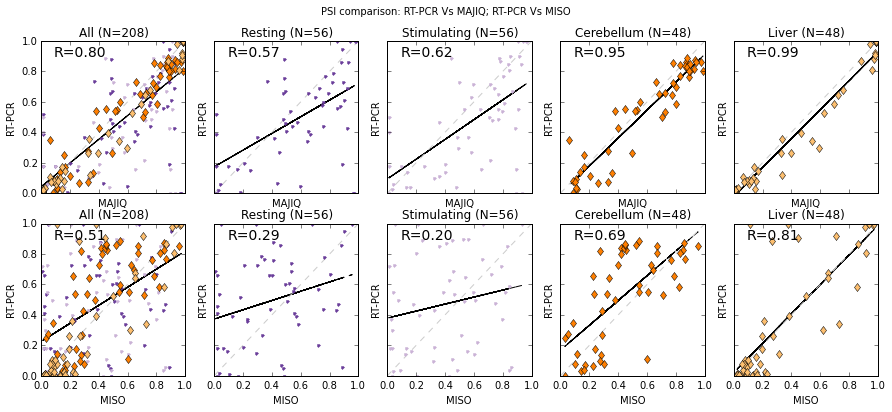

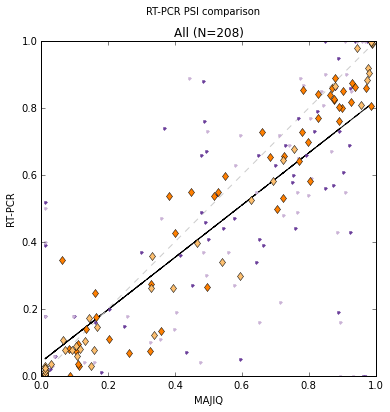

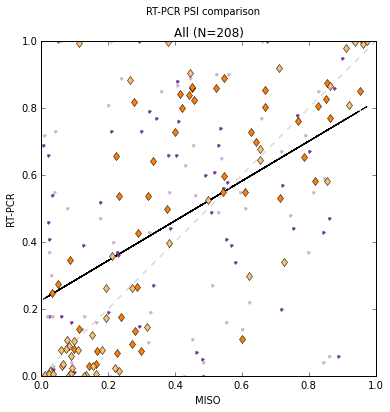

In [6]:
main(args_to_parse='../data/fig2_BC/rtPCR_comp/RTPCR_PSI_values --majiq-rest ../data/fig2_BC/Kristen/Unstim_psigroup.pickle  --majiq-stim ../data/fig2_BC/Kristen/Stim_psigroup.pickle  --names-map-file ../data/fig2_BC/rtPCR_comp/pcr_junctions_Extra.tab --miso-rest ../data/fig2_BC/Kristen/miso/rest --miso-stim ../data/fig2_BC/Kristen/miso/stim --pcr-extra ../data/fig2_BC/Hogenesch/Liv_v_Cer_RTPCR_by_replicate_final_with_JUNCTIONS.txt --miso-extra ../data/fig2_BC/Hogenesch/miso/Cer ../data/fig2_BC/Hogenesch/miso/Liv --majiq-extra ../data/fig2_BC/Hogenesch/Cer_284052_psigroup.pickle ../data/fig2_BC/Hogenesch/Liv_284052_psigroup.pickle --plotpath ../data/fig2_BC/'.split())